In [ ]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from urllib.parse import urlparse

In [ ]:
# Veri Setini Yükleme
file_path = "phishing_site_url.csv"  # Dosyanın bulunduğu yolu belirtin
df = pd.read_csv(file_path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [ ]:
print("\n Veri seti boyutu:")
print(df.shape)


 Veri seti boyutu:
(549346, 2)


In [ ]:
# Eksik değer kontrolü
print("\n Eksik Değer Sayısı:")
print(df.isnull().sum())


 Eksik Değer Sayısı:
URL      0
Label    0
dtype: int64


In [ ]:
# Etiket (Label) dağılımı
print("\n Etiket Dağılımı:")
print(df['Label'].value_counts())


 Etiket Dağılımı:
Label
good    392924
bad     156422
Name: count, dtype: int64


In [ ]:
print("\n Benzersiz etiketler:")
print(df['Label'].unique())


 Benzersiz etiketler:
['bad' 'good']


In [ ]:
# Yinelenen satır sayısını bul
yinelenen_sayi = df.duplicated().sum()
print(f" Yinelenen kayıt sayısı: {yinelenen_sayi}")

 Yinelenen kayıt sayısı: 42150


In [ ]:
df = df.drop_duplicates()
print(f" Yinelenen satırlar temizlendi. Yeni veri seti boyutu: {df.shape}")

 Yinelenen satırlar temizlendi. Yeni veri seti boyutu: (507196, 2)


In [ ]:
print("Etiket dağılımı (Label):")
print(df['Label'].value_counts())

Etiket dağılımı (Label):
Label
good    392897
bad     114299
Name: count, dtype: int64


In [ ]:
print("Veri seti bilgisi:")
print(df.info())

Veri seti bilgisi:
<class 'pandas.core.frame.DataFrame'>
Index: 507196 entries, 0 to 516470
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507196 non-null  object
 1   Label   507196 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB
None


In [ ]:
# Kategorik Değerlerin İşlenmesi
df['Label'] = df['Label'].map({'good': 1, 'bad': 0})

print(df.head())


                                                 URL  Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...      0
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      0
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....      0
3  mail.printakid.com/www.online.americanexpress....      0
4  thewhiskeydregs.com/wp-content/themes/widescre...      0


In [ ]:
# Temel İstatistiksel Özet
print("\nEtiket Dağılımı:")
print(df['Label'].value_counts(normalize=True) * 100)  # Yüzde olarak gösterim


Etiket Dağılımı:
Label
1    77.46453
0    22.53547
Name: proportion, dtype: float64


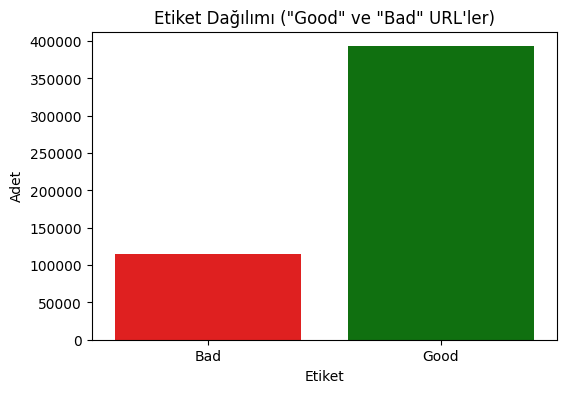

In [ ]:
# Etiket dağılımı
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'], palette=['red', 'green'])
plt.title('Etiket Dağılımı ("Good" ve "Bad" URL\'ler)')
plt.xlabel('Etiket')
plt.ylabel('Adet')
plt.xticks([0, 1], ["Bad", "Good"])
plt.show()

METİN ÖNİŞLEME
Sadece kücük harfe cevirme işlemi yapıldı. url ile çalıştığımız için url yapısına zarar vermeden ön işlem yapmaK gerekiyor.

In [ ]:
# URL'leri küçük harfe çevirme
df['URL'] = df['URL'].str.lower()

In [ ]:
# TF-IDF vektörleştirici
vectorizer = TfidfVectorizer(max_features=30000)
X_text = vectorizer.fit_transform(df['URL'])

print("TF-IDF vektör boyutu:", X_text.shape)


TF-IDF vektör boyutu: (507196, 30000)


TF-IDF Vectorizer:	URLs içindeki kelime/karakter yapılarını vektörleştirmek
max_features=30000	En çok geçen 30,000 kelime (veya token) üzerinden bir temsil oluşturmak
fit_transform	URL metinlerini 30000 boyutlu sayısal vektörlere çevirmek

In [ ]:
# Manuel özellik çıkarımı fonksiyonu
def extract_manual_features(df):
    df_feat = pd.DataFrame()
    df_feat['url_length'] = df['URL'].apply(len)
    df_feat['count_dot'] = df['URL'].apply(lambda x: x.count('.'))
    df_feat['count_hyphen'] = df['URL'].apply(lambda x: x.count('-'))
    df_feat['count_at'] = df['URL'].apply(lambda x: x.count('@'))
    df_feat['count_question'] = df['URL'].apply(lambda x: x.count('?'))
    df_feat['count_percent'] = df['URL'].apply(lambda x: x.count('%'))
    df_feat['count_numbers'] = df['URL'].apply(lambda x: sum(c.isdigit() for c in x))
    df_feat['count_letters'] = df['URL'].apply(lambda x: sum(c.isalpha() for c in x))
    df_feat['digit_ratio'] = df_feat['count_numbers'] / df_feat['url_length']
    df_feat['has_https'] = df['URL'].apply(lambda x: int(x.startswith('https')))
    df_feat['has_ip'] = df['URL'].apply(lambda x: int(any(char.isdigit() for char in x.split('/')[2]) if '://' in x else False))
    return df_feat

# Manuel özellikleri çıkar
df_manual_features = extract_manual_features(df)

# Kontrol edelim
print("Manuel Özellikler hazır:", df_manual_features.shape)



Manuel Özellikler hazır: (507196, 11)


In [ ]:
print(df_manual_features.head())

   url_length  count_dot  count_hyphen  count_at  count_question  \
0         225          6             4         0               1   
1          81          5             2         0               0   
2         177          7             1         0               0   
3          60          6             0         0               0   
4         116          1             1         0               1   

   count_percent  count_numbers  count_letters  digit_ratio  has_https  has_ip  
0              0             58            135     0.257778          0       0  
1              0              1             65     0.012346          0       0  
2              0             47            111     0.265537          0       0  
3              0              0             52     0.000000          0       0  
4              0             21             82     0.181034          0       0  


URL'nin uzunluğu, çok tire kullanımı gibi dolandırıcıların kullandığı yapısal ipuçları içeriyor.

In [ ]:
from scipy import sparse
from scipy.sparse import hstack

# Manuel özellikleri sparse formata çevir
X_manual = df_manual_features.values
X_manual_sparse = sparse.csr_matrix(X_manual)
# TF-IDF ve Manuel özellikleri birleştir
X_combined = hstack([X_text, X_manual_sparse])

print("Birleşik özellik vektör şekli:", X_combined.shape)


Birleşik özellik vektör şekli: (507196, 30011)


Sadece TF-IDF ➔ URL'nin ne yazdığına bakıyor.

Sadece Manuel Özellikler ➔ URL'nin nasıl yazıldığına bakıyor.

İkisini birleştirince ➔ Model hem ne hem nasıl yazıldığını birlikte değerlendiriyor

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, df['Label'],
    test_size=0.25,
    random_state=42,
    stratify=df['Label']
)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)



Eğitim seti boyutu: (380397, 30011)
Test seti boyutu: (126799, 30011)


In [ ]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


# 1. Random Forest Modeli
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\n🟢 Random Forest Sonuçları")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))



🟢 Random Forest Sonuçları
Accuracy: 0.9706306832072809
              precision    recall  f1-score   support

           0       0.96      0.91      0.93     28575
           1       0.97      0.99      0.98     98224

    accuracy                           0.97    126799
   macro avg       0.97      0.95      0.96    126799
weighted avg       0.97      0.97      0.97    126799



In [ ]:
# 2. Naive Bayes Modeli
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_preds = nb_model.predict(X_test)

print("\n🟣 Naive Bayes Sonuçları")
print("Accuracy:", accuracy_score(y_test, nb_preds))
print(classification_report(y_test, nb_preds))


🟣 Naive Bayes Sonuçları
Accuracy: 0.8922625572756883
              precision    recall  f1-score   support

           0       0.79      0.71      0.75     28575
           1       0.92      0.95      0.93     98224

    accuracy                           0.89    126799
   macro avg       0.85      0.83      0.84    126799
weighted avg       0.89      0.89      0.89    126799



In [ ]:
# Logistic Regression modeli oluştur
lr_model = LogisticRegression(max_iter=1600, random_state=42)
lr_model.fit(X_train, y_train)

# Tahmin
lr_preds = lr_model.predict(X_test)

# Sonuçları yazdır
print("\n🟠 Logistic Regression Sonuçları")
print("Accuracy:", accuracy_score(y_test, lr_preds))
print(classification_report(y_test, lr_preds))


🟠 Logistic Regression Sonuçları
Accuracy: 0.9572078644153345
              precision    recall  f1-score   support

           0       0.96      0.85      0.90     28575
           1       0.96      0.99      0.97     98224

    accuracy                           0.96    126799
   macro avg       0.96      0.92      0.94    126799
weighted avg       0.96      0.96      0.96    126799



In [ ]:
from sklearn.svm import LinearSVC

# SVM modeli oluştur
svm_model = LinearSVC(max_iter=1500, random_state=42)
svm_model.fit(X_train, y_train)

# Tahmin
svm_preds = svm_model.predict(X_test)

# Sonuçları yazdır
print("\n🔵 SVM (Linear Kernel) Sonuçları")
print("Accuracy:", accuracy_score(y_test, svm_preds))
print(classification_report(y_test, svm_preds))


🔵 SVM (Linear Kernel) Sonuçları
Accuracy: 0.9665849099756307
              precision    recall  f1-score   support

           0       0.96      0.89      0.92     28575
           1       0.97      0.99      0.98     98224

    accuracy                           0.97    126799
   macro avg       0.97      0.94      0.95    126799
weighted avg       0.97      0.97      0.97    126799



In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_scores, model_name="Model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


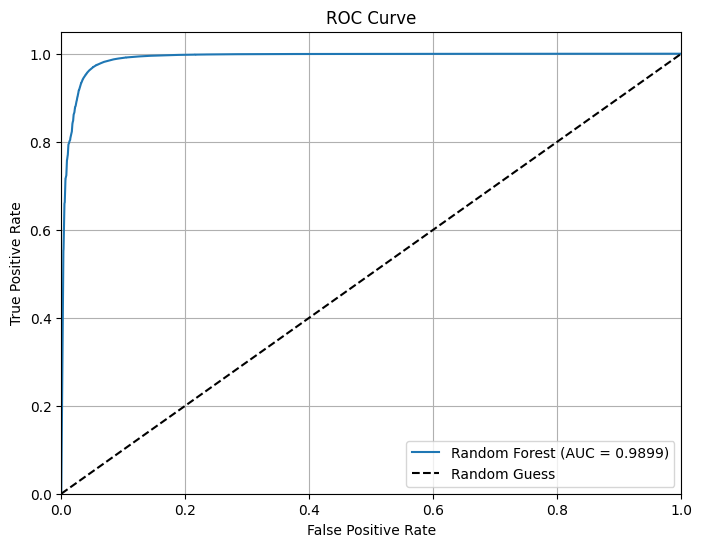

In [ ]:
# Random Forest olasılık skorlarını al
rf_probs = rf_model.predict_proba(X_test)[:, 1]  # Sınıf 1'in olasılığı

# ROC eğrisini çiz
plot_roc_curve(y_test, rf_probs, model_name="Random Forest")


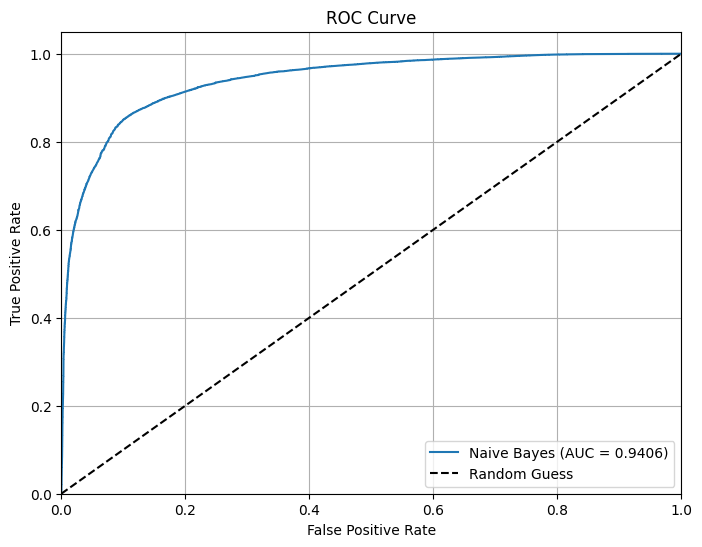

In [ ]:
# Naive Bayes olasılık skorlarını al
nb_probs = nb_model.predict_proba(X_test)[:, 1]  # Sınıf 1'in (Good) olasılığı

# ROC eğrisini çiz
plot_roc_curve(y_test, nb_probs, model_name="Naive Bayes")


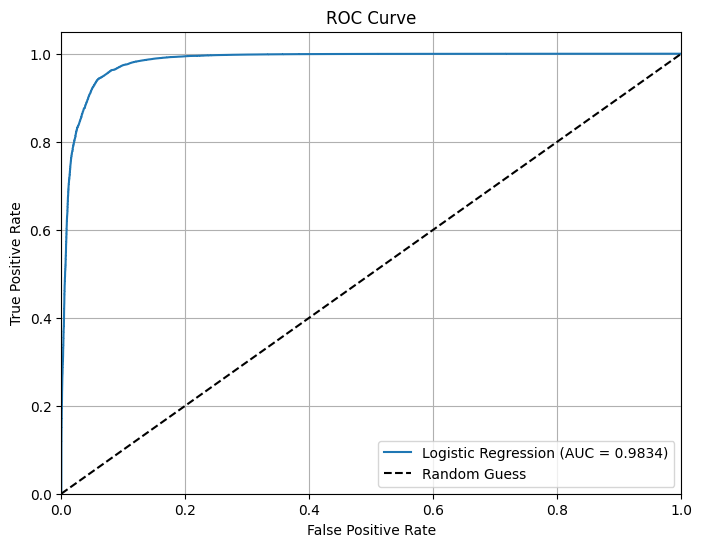

In [ ]:
lr_probs = lr_model.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, lr_probs, model_name="Logistic Regression")


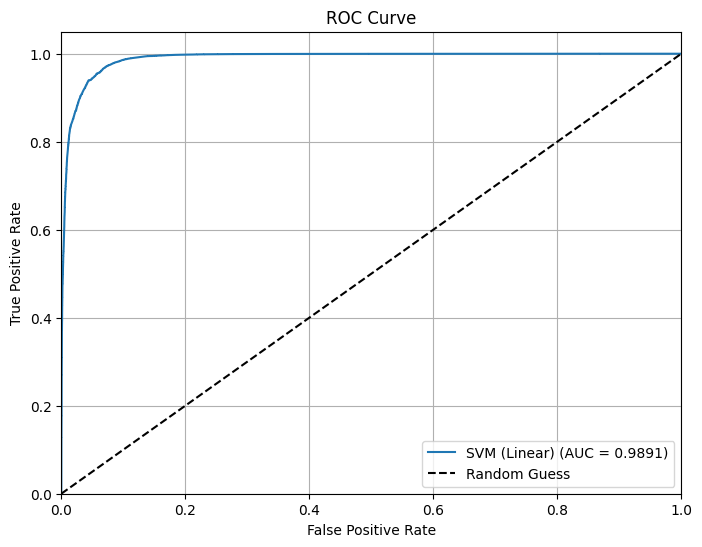

In [ ]:
svm_scores = svm_model.decision_function(X_test)
plot_roc_curve(y_test, svm_scores, model_name="SVM (Linear)")

Bu tabloda, farklı makine öğrenmesi algoritmalarının phishing URL tespiti üzerindeki performansları karşılaştırılmıştır. Değerlendirmede, beş temel metrik esas alınmıştır: Accuracy, Precision, Recall, F1 Score ve AUC (Area Under the ROC Curve).

✅ Random Forest
En yüksek Accuracy (%97.11) ve F1 Score (%98.15) değerlerine ulaşmıştır.

Recall (%98.94) ve Precision (%97.37) dengeli ve yüksektir.

AUC skoru (0.9893), modelin pozitif ve negatif sınıfları ayırt etme başarısının mükemmele yakın olduğunu gösterir.

Sonuç: Hem güvenli URL'leri doğru tanıma hem de phishing URL'leri kaçırmama açısından en başarılı modeldir. Üretim ortamı için en uygun seçenek olarak öne çıkmaktadır.

🔵 Support Vector Machine (SVM)
En yüksek Recall oranı (%99.05) ile phishing URL’leri tespit etmede olağanüstü performans göstermektedir.

Precision ve F1 skorları da oldukça yüksektir (%96.75 – %97.88).

AUC değeri de oldukça güçlü (0.9889).

Sonuç: Özellikle kaçırılmaması gereken tehditlerin öncelikli olduğu sistemlerde (örneğin güvenlik uygulamaları) SVM etkili bir tercih olabilir.

🟠 Logistic Regression
Dengeli bir performans sunmaktadır (Accuracy %95.73, F1 Score %97.29).

Precision yüksek (%95.64) ancak Recall (%90.00) Random Forest ve SVM'nin gerisindedir.

AUC değeri oldukça iyidir (0.9843).

Sonuç: Özellikle yorumlanabilirliğin önemli olduğu durumlarda (örneğin regülasyona tabi sistemlerde) tercih edilebilir.

🟣 Naive Bayes
Diğer modellere göre en düşük performansa sahiptir (Accuracy %89.34, AUC 0.9410).

Yine de Recall (%94.59) tatmin edici düzeydedir.

Modelin basitliği ve hızlı eğitilme avantajı sayesinde küçük veri setlerinde veya ilk prototiplerde kullanılabilir.

Sonuç: Performansı düşük olmasına rağmen hızlı prototipleme veya kaynak kısıtlı ortamlarda tercih edilebilir.

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np

# 1. BERT modeli (hafif ve hızlı)
model = SentenceTransformer('all-MiniLM-L6-v2')  # 384 boyutlu embedding üretir

# 2. URL'leri küçük harfe çevir
df['URL_clean'] = df['URL'].str.lower()

# 3. Embedding vektörlerini çıkar
bert_embeddings = model.encode(df['URL_clean'].tolist(), show_progress_bar=True)

# 4. Numpy array olarak boyut kontrolü
print("BERT embedding boyutu:", bert_embeddings.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/15850 [00:00<?, ?it/s]

BERT embedding boyutu: (507196, 384)


In [ ]:
# X = BERT vektörleri
# y = Etiketler
X = bert_embeddings
y = df['Label'].values

# Eğitim/test seti ayırımı
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)


Eğitim seti boyutu: (405756, 384)
Test seti boyutu: (101440, 384)


In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# ANN modeli
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification için sigmoid
])

# Modeli derle
ann_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Modelin özetini yazdır (opsiyonel)
ann_model.summary()

# Modeli eğit
history = ann_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               98560     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 131585 (514.00 KB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
3170/

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# 2. LSTM Modeli kur
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# 3. Modeli derle
lstm_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Model özeti
lstm_model.summary()

# 5. Eğit
history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=128,
    verbose=1
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74881 (292.50 KB)
Trainable params: 74881 (292.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3170/

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split


#  CNN Modeli kur
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(128, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])

# Modeli derle
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

#  Model özeti
cnn_model.summary()

# Eğit
history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128,
    verbose=1
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 380, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 190, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 186, 64)           41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 93, 64)            0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 5952)              0         
                                                                 
 dense_7 (Dense)             (None, 64)               